In [210]:
from math import *
import random
import numpy as np
import matplotlib.pyplot as plt



landmarks=[[0.0, 0.0],
           [5.0, 0.0],
           [5.0, 5.0],
           [0.0, 5.0]
          ]


world_size = 5.0

In [211]:


class robot:
    def __init__(self):
        self.x = random.random() * world_size
        self.y = random.random() * world_size
        self.k = 36
        self.forward_noise = 0.0;
        self.turn_noise    = 0.0;
        self.sense_noise   = 0.0;
    
    def set(self, new_x, new_y):
        if new_x < 0 or new_x >= world_size:
            raise ValueError ('X coordinate out of bound')
        if new_y < 0 or new_y >= world_size:
            raise ValueError ('Y coordinate out of bound')
        self.x = float(new_x)
        self.y = float(new_y)
    
    
    def set_noise(self, new_f_noise, new_t_noise, new_s_noise):
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.forward_noise = float(new_f_noise);
        self.turn_noise    = float(new_t_noise);
        self.sense_noise   = float(new_s_noise);
    
    
    def move(self, x, y):         
        
        x = float(x) + random.gauss(0.0, self.forward_noise)
        y = float(y) + random.gauss(0.0, self.forward_noise)
        x = self.x + x
        y = self.y + y
        x %= world_size    # cyclic truncate
        y %= world_size
        
        # set particle
        res = robot()
        res.set(x, y)
        res.set_noise(self.forward_noise, self.turn_noise, self.sense_noise)
        return res
    
    def Gaussian(self, mu, sigma, x):
        
        # calculates the probability of x for 1-dim Gaussian with mean mu and var. sigma
        return exp(- ((mu - x) ** 2) / (sigma ** 2) / 2.0) / sqrt(2.0 * pi * (sigma ** 2))
    
    
    def measurement_prob(self, measurement):        
        # calculates how likely a measurement should be
        senseZ = self.sense(landmarks)
        prob = 1.0;
        for i in range(len(landmarks)):
            prob *= self.Gaussian(senseZ[i], self.sense_noise, measurement[i])
        return prob
      
    def __repr__(self):
        return '[x=%.6s y=%.6s]' % (str(self.x), str(self.y))
    
    def line_intersect(self,A1,A2,B1,B2):
        x1=A1[0]
        y1=A1[1]
        x2=A2[0]
        y2=A2[1]
        x3=B1[0]
        y3=B1[1]
        x4=B2[0]
        y4=B2[1]

        x = ((x1*y2 -y1*x2)*(x3-x4) - (x1-x2)*(x3*y4-y3*x4))/((x1-x2)*(y3-y4) - (y1-y2)*(x3-x4)+0.000001)
        y = ((x1*y2 -y1*x2)*(y3-y4) - (y1-y2)*(x3*y4-y3*x4))/((x1-x2)*(y3-y4) - (y1-y2)*(x3-x4)+0.000001)
        return x,y

    def findDist(self, A1,A2,B1,B2):

        x,y = line_intersect(A1,A2,B1,B2)

        dist = sqrt((A1[0] - x) ** 2 + (A1[1] - y) ** 2)

        return dist, x,y


    def secondDot(self, x,y,angle):
        dist = 99999999
        return [x+cos(angle) * dist , y+sin(angle) *dist]

    def checkAngle(self,x0,y0,x,y,angle):
        boole = True

        dist = sqrt((x0 - x) ** 2 + (y0 - y) ** 2)

        co = (x-x0)/dist
        si = (y-y0)/dist

        if co<0.0001 and co>-0.0001:
            co=0
        if si<0.0001 and si>-0.0001:
            si=0

        Cos = cos(angle)
        Sin = sin(angle)

        if Cos<0.0001 and Cos>-0.0001:
            Cos=0
        if Sin<0.0001 and Sin>-0.0001:
            Sin=0


        return np.sign(Cos)  ==  np.sign(co) and np.sign(Sin)  ==  np.sign(si)



    def findMinDist(self,landmark, x,y, angle):

        A1 = [x,y]
        B1 = secondDot(x,y,angle)

        minDist = 9999999

        for i in range(len(landmark)):
            if i == len(landmark)-1:
                A = landmark[i]
                B = landmark[0]
            else:
                A = landmark[i]
                B = landmark[i+1]

            distAB = sqrt((A[0] - B[0]) ** 2 + (A[1] - B[1]) ** 2)

            dist, X, Y = findDist(A1, B1, A, B)

            distXYA = sqrt((A[0] - X) ** 2 + (A[1] - Y) ** 2)
            distXYB = sqrt((B[0] - X) ** 2 + (B[1] - Y) ** 2)

            if distXYA > distAB or distXYB > distAB:
                dist = 99999999


            if  checkAngle(x,y, X,Y, angle) and minDist > dist:
                minDist = dist



        return minDist

    def sense(self,landmark):
        x= self.x
        y= self.y
        k = self.k
        dangle = 2*pi/k
        Z = []

        angle=0

        for i in range(k):
            Z.append(findMinDist(landmark, x,y, angle))
            angle+=dangle

        return Z

    


In [212]:
def plotIt(p, world_size):
    array=[[0 for i in range(int(world_size))] for j in range(int(world_size))]

    ln = len(p)

    for i in range(ln):
        array[int(p[i].x)][int(p[i].y)] = 255

    plt.imshow(array, "gray")
    plt.title('Image BW 1')

In [213]:
rob = robot()
rob.set_noise(0.01, 0.01, 0.01)
rob.set(1.0, 1.0)
Z = rob.sense(landmarks)

print(rob)
print(Z)

[x=1.0 y=1.0]
[3.9999999999999902, 4.061706447542969, 4.256711089903636, 4.6188021535169925, 5.2216291573290965, 5.2216291573290965, 4.618802153516992, 4.256711089903637, 4.061706447542969, 3.9999999999999902, 4.06170644754297, 2.9238044001630668, 1.9999999999999913, 1.5557238268604079, 1.3054072893322761, 1.1547005383792504, 1.0641777724759116, 1.0154266118857447, 1.0, 1.015426611885745, 1.0641777724759118, 1.1547005383792506, 1.3054072893322766, 1.3054072893322812, 1.1547005383792535, 1.0641777724759136, 1.0154266118857458, 1.0, 1.015426611885744, 1.0641777724759098, 1.1547005383792472, 1.3054072893322715, 1.5557238268604, 1.9999999999999765, 2.9238044001630317, 4.061706447542973]


In [180]:
N = 1000
p = []
for i in range(N):
    x = robot()
    x.set_noise(0.01, 0.01, 0.01)
    p.append(x)

In [193]:
def oneStep(p):
    p2 = []
    for i in range(N):
        p2.append(p[i].move(0.1, 5.0))
    p = p2
    
    w = []
    for i in range(N):
        w.append(p[i].measurement_prob(Z))
        
        
    p3 = []
    index = int(random.random() * N)
    beta = 0.0
    mw = max(w)
    for i in range(N):
        beta += random.random() * 2.0 * mw
        while beta > w[index]:
            beta -= w[index]
            index = (index + 1) % N
        p3.append(p[index])
    p = p3
        
    return p
    
def shum(p):
    for rob in p:
        rob.set(rob.x+(random.random()*2 - 1),rob.y+(random.random()*2 - 1))
    return p
    

In [206]:
p = oneStep(p)

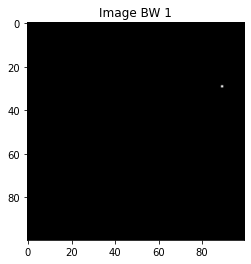

In [207]:
plotIt(p, world_size)

In [201]:
p = shum(p)